In [1]:
import os
import numpy as np
import pandas as pd
import numpy.linalg as LA

In [2]:
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

In [4]:
tqdm.pandas()

In [5]:
pj = os.path.join


set *root* to your root folder where the csv file is
csv file can be downloaded from https://www.federalreserve.gov/data/nominal-yield-curve.htm


In [6]:
fed_data = pd.read_csv('FedBondYieldData_20230911.csv', skiprows=9)
fed_data['Date'] = pd.to_datetime(fed_data.Date)
fed_data.set_index('Date', inplace=True)

In [7]:
zero_yields_cols = [c for c in fed_data.columns if c.find('SVENY')>-1]

zero_yields = fed_data[zero_yields_cols]

zero_yields=zero_yields.rename(columns=dict(zip(zero_yields_cols, [int(c[-2:]) for c in zero_yields_cols])))

In [8]:
par_yields_cols = [c for c in fed_data.columns if c.find('SVENPY')>-1]

par_yields = fed_data[par_yields_cols]

par_yields=par_yields.rename(columns=dict(zip(par_yields_cols, [int(c[-2:]) for c in par_yields_cols])))

In [9]:
start_date = par_yields[30].dropna().index[0]

In [11]:
yields = par_yields[start_date:].dropna()

In [12]:
yields.columns.rename('tenor', inplace=True)

In [13]:
lag_deltay = yields.diff(1)
lead_deltay = lag_deltay.shift(-1)

In [14]:
lead_deltay.columns.rename('Maturity', inplace=True)

In [15]:
(lag_deltay[[2,3,5,7,10,30]].corr().round(3)*100)

Maturity,2,3,5,7,10,30
Maturity,,,,,,
2,100.0,98.4,92.7,87.2,81.0,68.3
3,98.4,100.0,97.3,92.8,87.0,74.8
5,92.7,97.3,100.0,98.6,94.6,83.8
7,87.2,92.8,98.6,100.0,98.5,88.9
10,81.0,87.0,94.6,98.5,100.0,92.4
30,68.3,74.8,83.8,88.9,92.4,100.0


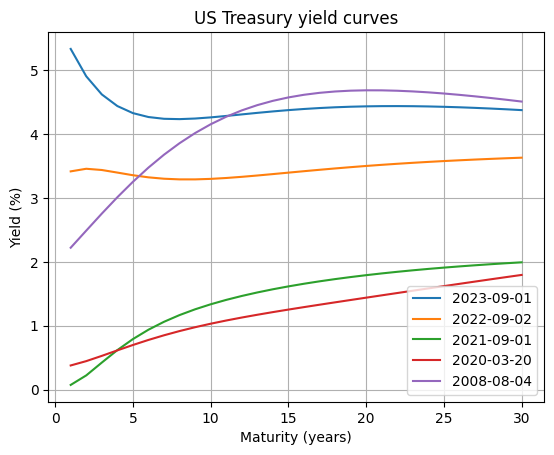

In [16]:
df = yields.dropna()

base=df.index[0]

fig = plt.figure()
ax = plt.axes()
dates=[pd.Timestamp('20230901'), pd.Timestamp('20220902'), pd.Timestamp('20210901'),pd.Timestamp('20200320'),pd.Timestamp('20080804')]
for row in df.loc[dates].iterrows():
    y=row[1].index.to_numpy()
    z=row[1].to_numpy()
    x = np.array([(row[0]-base)/pd.offsets.Day(1)/365]*z.size)
    (row[1]).plot(label=row[0].strftime('%Y-%m-%d'), ax=ax)
    ax.legend()
    ax.set_ylabel('Yield (%)')
    ax.set_xlabel('Maturity (years)')
    ax.set_title('US Treasury yield curves')
    ax.grid(True)

In [17]:
cov = lag_deltay.dropna().rolling(window=504, min_periods=504).cov().dropna()

In [18]:
cov.columns.rename('tenor', inplace=True)

In [19]:
def eigenvectors(cov, n_factors=3):
    eigvectors = LA.eigh(cov)[1]
    dfout = pd.DataFrame(index=cov.index, columns=pd.RangeIndex(eigvectors.shape[1],0,step=-1,name='factor'), data=eigvectors)
    return dfout    

def eigenvalues(cov, n_factors=3):
    eigvalues = LA.eigvalsh(cov)
    dfout = pd.DataFrame(index=pd.RangeIndex(eigvalues.shape[0],0,step=-1,name='factor'), data=eigvalues).transpose()
    return dfout

In [20]:
loadings = cov.groupby('Date').progress_apply(eigenvectors).sort_index(axis=1)

 18%|█▊        | 1584/8926 [00:00<00:01, 3949.93it/s]

100%|██████████| 8926/8926 [00:02<00:00, 3684.71it/s]


In [21]:
loadings.index.rename(['Date','tenor'], inplace=True)

ValueError: Length of names must match number of levels in MultiIndex.

In [ ]:
eigenvalues = cov.groupby('Date').progress_apply(eigenvalues).reset_index(level=1, drop=True).sort_index(axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 8926/8926 [00:08<00:00, 1060.24it/s]


In [ ]:
pcs = np.array(list(range(1,6)))

In [ ]:
norm_loadings = loadings[pcs]
norm_loadingsT = norm_loadings.stack().unstack(level='tenor')
sign = np.sign(norm_loadingsT[range(20,31)].sum(axis=1))

norm_loadingsT = norm_loadingsT.multiply(sign, axis=0)
norm_loadings = norm_loadingsT.stack().unstack(level='factor')

In [ ]:
var_explained = eigenvalues.apply(lambda x: x/x.sum(), axis=1)

Text(0.5, 1.0, 'Variance explained of first 3 factors')

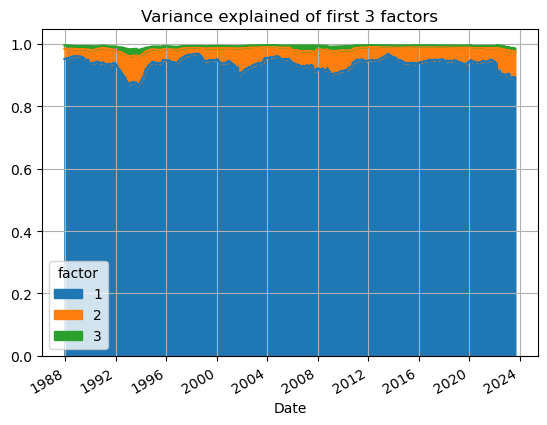

In [ ]:
var_explained[[1,2,3]].plot.area()
plt.grid(True)
plt.title('Variance explained of first 3 factors')

In [ ]:
factor_pct_explain = eigenvalues.div(eigenvalues.sum(axis=1), axis=0)


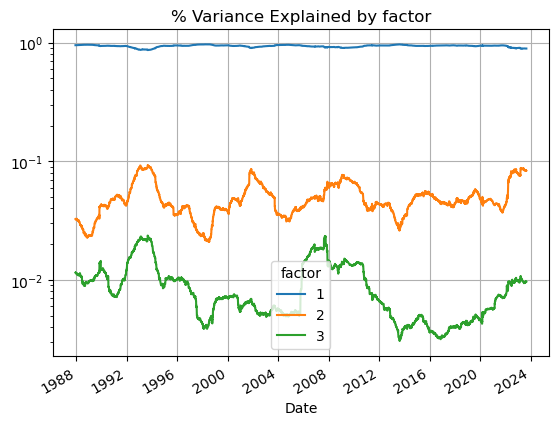

In [ ]:
factor_pct_explain.iloc[:,:3].plot()
plt.yscale('log')
plt.title('% Variance Explained by factor')
plt.grid(True)

In [ ]:
pc_start_date = norm_loadings.iloc[0].name[0]
pc_start_date = pd.Timestamp('20000101')

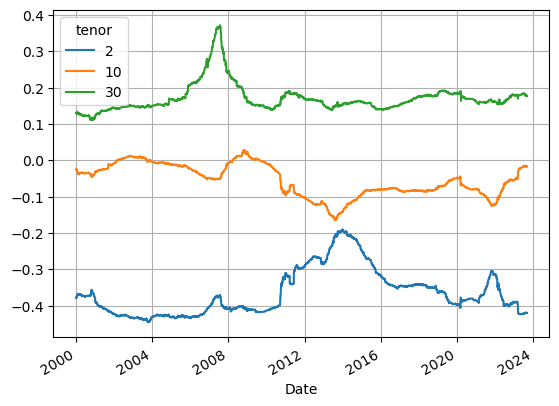

In [ ]:
norm_loadingsT[pc_start_date:].xs(2, level='factor')[[2,10,30]].plot()
plt.grid(True)

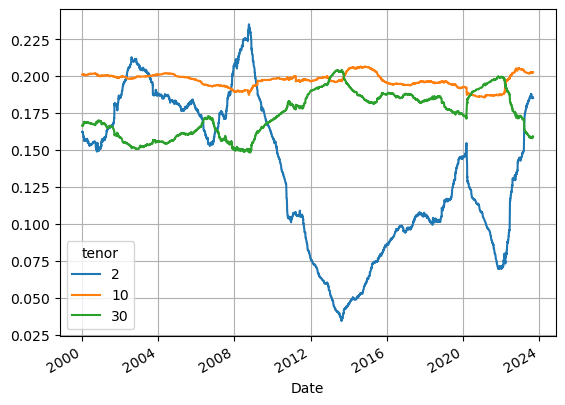

In [ ]:
norm_loadingsT[pc_start_date:].xs(1, level='factor')[[2,10,30]].plot()
plt.grid(True)

Text(0.5, 1.0, 'PC1 loadings stability')

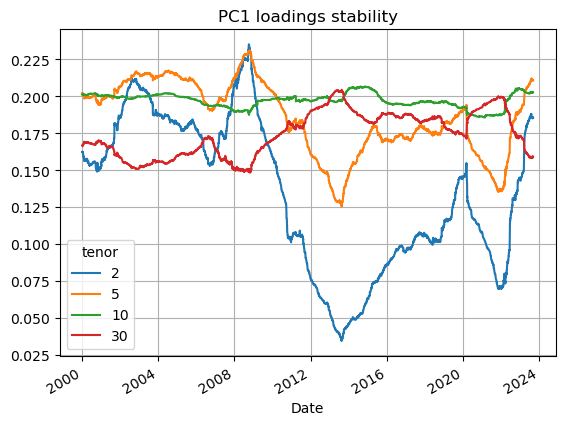

In [ ]:
norm_loadingsT[pc_start_date:].xs(1, level='factor')[[2,5,10,30]].plot()
plt.grid(True)
plt.title('PC1 loadings stability')

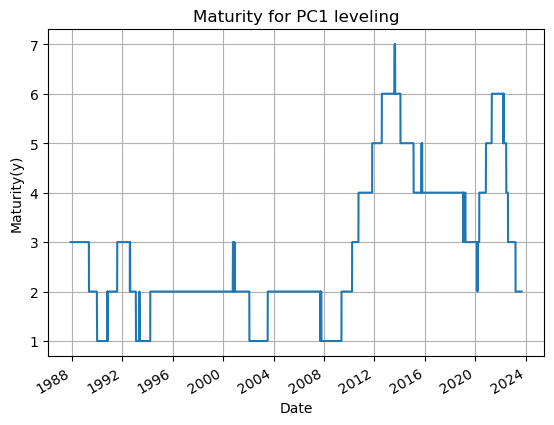

In [ ]:
norm_loadingsT.xs(1, level='factor').apply(lambda x: x.index[np.argmax(x>0.15)], axis=1).plot()
plt.title("Maturity for PC1 leveling")
plt.ylabel('Maturity(y)')
plt.grid(True)

Text(0, 0.5, 'Maturity(y)')

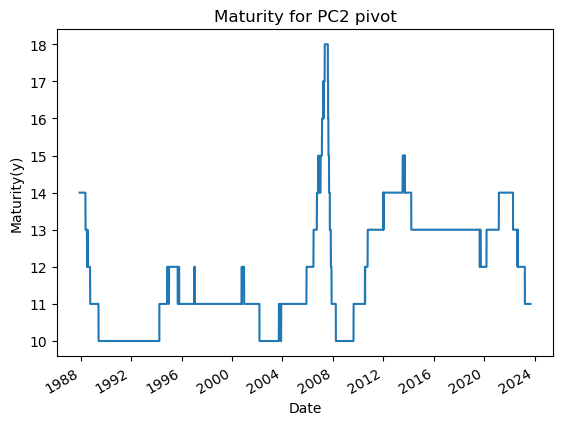

In [ ]:
norm_loadingsT.xs(2, level='factor').apply(lambda x: x.index[np.argmax(x>0)], axis=1).plot()
plt.title("Maturity for PC2 pivot")
plt.ylabel('Maturity(y)')

In [ ]:
belly=pd.DataFrame()
belly['bottom'] = norm_loadingsT.xs(3, level='factor').apply(lambda x: x.index[np.argmax(-x)], axis=1)
belly['start'] = norm_loadingsT.xs(3, level='factor').apply(lambda x: x.index[np.argmax(x<0)], axis=1)
belly['end'] = norm_loadingsT.xs(3, level='factor').apply(lambda x: x.index[x.size-1-np.argmax(np.flip(x)<0)], axis=1)

<Axes: xlabel='Date'>

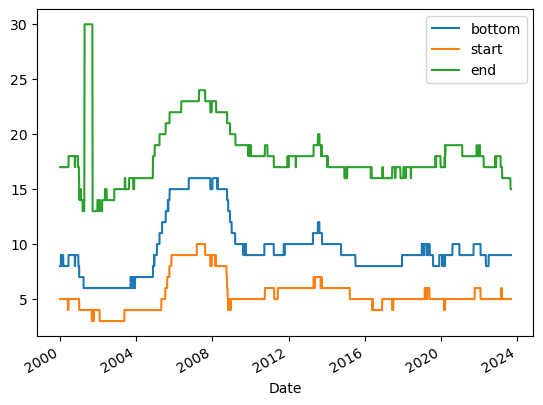

In [ ]:
belly[pc_start_date:].plot()


In [ ]:
dr=pd.DataFrame(index=(pd.date_range(pc_start_date, periods=5, freq='5Y') + pd.offsets.Day(10)).rename('Date'))

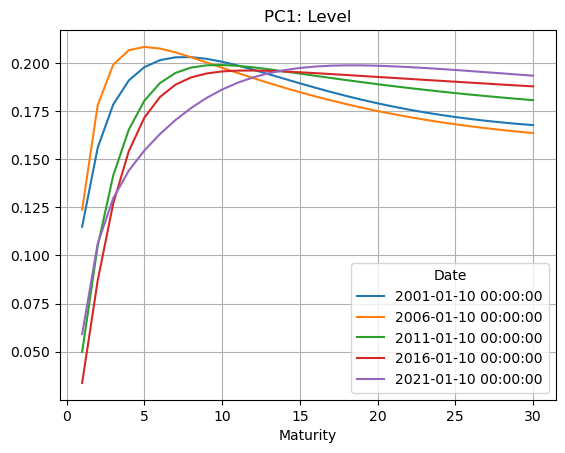

In [ ]:
pd.merge_asof(dr, norm_loadingsT.xs(1, level='factor'), left_index=True, right_index=True).transpose().plot()
plt.grid(True)
plt.xlabel('Maturity')
plt.title(f'PC1: Level');

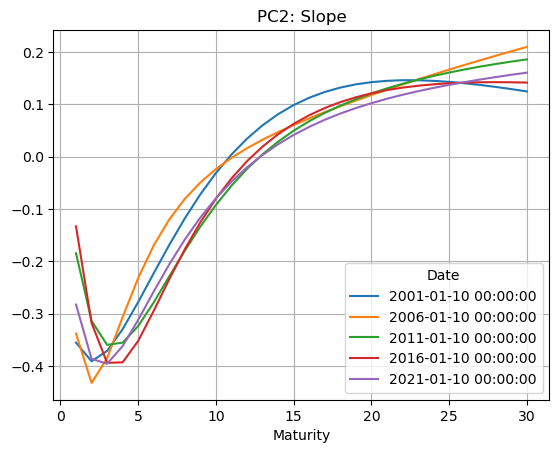

In [ ]:
pd.merge_asof(dr, norm_loadingsT.xs(2, level='factor'), left_index=True, right_index=True).transpose().plot()
plt.grid(True)
plt.xlabel('Maturity')
plt.title(f'PC2: Slope');

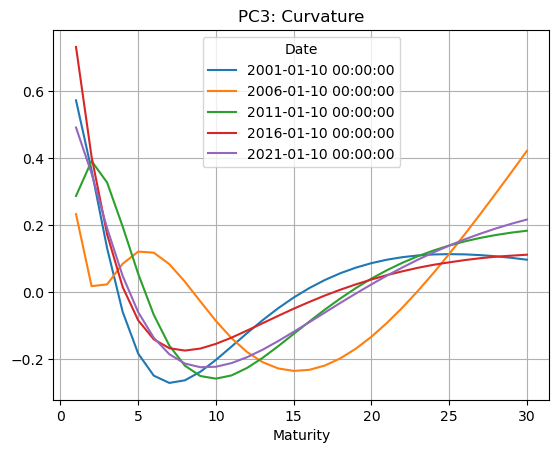

In [ ]:
pd.merge_asof(dr, norm_loadingsT.xs(3, level='factor'), left_index=True, right_index=True).transpose().plot()
plt.grid(True)
plt.xlabel('Maturity')
plt.title(f'PC3: Curvature');

In [ ]:
max_date = lead_deltay[pc_start_date:].dropna().iloc[-1].name

In [ ]:
pcs_5=list(range(1,6))
pcs_3=list(range(1,4))
pcs_3

[1, 2, 3]

In [ ]:
factor_lead_moves = pd.concat([(lead_deltay[pc_start_date:].dropna() * norm_loadingsT[pc_start_date:max_date].xs(i, level='factor')).sum(axis=1) for i in pcs_5], keys=pcs_5, axis=1)

In [ ]:
factor_lead_moves[pcs_3].corr()*100

,1,2,3
1,100.000000,4.028944,-0.221509
2,4.028944,100.000000,-9.018034
3,-0.221509,-9.018034,100.000000


In [ ]:
tenors = norm_loadingsT.columns
pc_component_moves = pd.concat([(factor_lead_moves * norm_loadings[pc_start_date:max_date].xs(i, level='tenor')) for i in tenors], keys=tenors, axis=0)

/Users/sandreev/opt/anaconda3/envs/python3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


Text(0, 0.5, 'ex-ante annual vol')

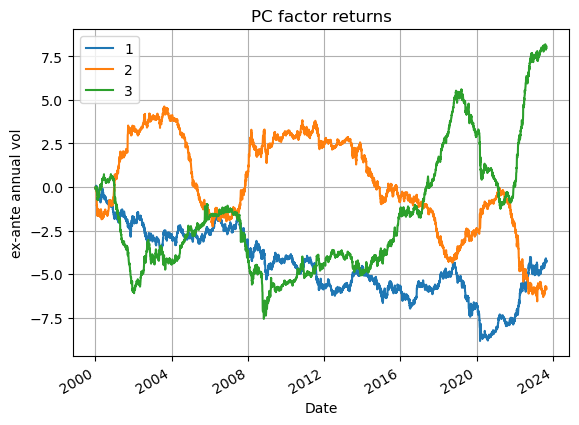

In [ ]:
factor_lead_moves.div(np.sqrt(eigenvalues*252))[pcs_3].cumsum().plot()
plt.title('PC factor returns')
plt.grid(True)
plt.ylabel('ex-ante annual vol')


In [ ]:
lead_deltay.columns.rename('tenor', inplace=True)

In [ ]:
x0=lead_deltay[pc_start_date:].stack()
pc_residuals = pc_component_moves.swaplevel(i=0, j=1).cumsum(axis=1).sort_index().transform(lambda x: x0-x)

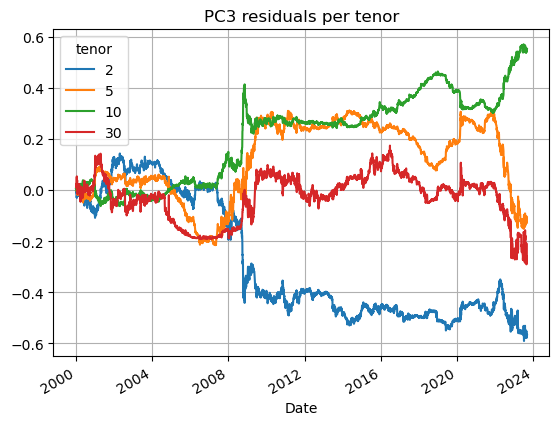

In [ ]:
resid = pc_residuals[3].unstack(level='tenor')
resid_zscore = (resid - resid.ewm(halflife=10).mean())/resid.ewm(halflife=10).std()

resid.cumsum()[[2,5,10,30]].plot()
plt.title('PC3 residuals per tenor')
#plt.ylabel('%')
plt.grid(True)

## Out of sample variance

In [ ]:
df_loadings=norm_loadings[pc_start_date:]

In [ ]:
def out_of_sample_var_explain(df, shift_size, factors=None):

    if factors is None:
        factors = df.columns
    nfactors = len(factors)
    factor_list = list(range(1,nfactors+1))
    df_shifted = df.unstack().shift(shift_size).stack().dropna()
    start_date = df_shifted.unstack().index[0]
    D=df[start_date:].groupby('Date').apply(lambda x: df_shifted.loc[x.name, factor_list].transpose() @ x.reset_index(level=0, drop=True))


    DLD = D.groupby('Date').apply(lambda x: pd.Series(np.diag(x @ np.diag(eigenvalues.loc[x.name, pcs]) @ x.to_numpy().T)))

    percent_explained=DLD.div(eigenvalues.loc[DLD.index].sum(axis=1), axis=0)
    return percent_explained

In [ ]:
shift_sizes = [0,30,60,180,252,504]

OSV = out_of_sample_var_explain(df_loadings, 504)

In [ ]:
OSV0 = out_of_sample_var_explain(df_loadings, 1)

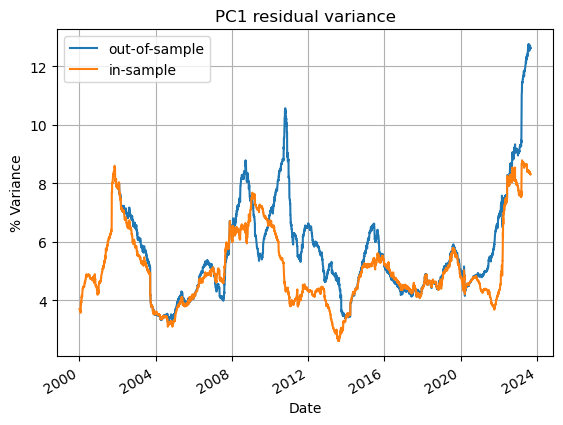

In [ ]:

ax=((OSV[1])*100).plot(label='out-of-sample')
((OSV0[1])*100).plot(ax=ax, label='in-sample')
ax.legend()
ax.set_title('PC1 residual variance')
ax.set_ylabel('% Variance')
ax.grid(True)

In [ ]:
tenors = [2,5,10]
df = df_loadings[[1,2]].reset_index(level=0)

In [ ]:
def neutral_weights(df):
    tenors = df.index
    #import pdb; pdb.set_trace()
    df1=df.drop(columns='Date')
    w=df1.loc[tenors[1:]].to_numpy().T
    b=-df1.loc[tenors[0]].to_numpy()
    res = np.linalg.solve(w, b)
    dfout=pd.DataFrame(index=tenors)
    weights = np.concatenate(([1],res))
    return pd.Series(index=tenors, data=weights/weights[1])
    
def neutral_weights_tenors(df, tenors):
    return df.loc[tenors].groupby('Date', group_keys=True).progress_apply(neutral_weights)

In [ ]:
tenors=[5,7,10]
weights = neutral_weights_tenors(df, tenors)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5922/5922 [00:08<00:00, 702.32it/s]


In [ ]:
pc_neutral_return = weights * lead_deltay.loc[weights.index, weights.columns]

In [ ]:
pc_neutral_return_agg = pc_neutral_return.sum(axis=1)

In [ ]:
pc_neutral_return_agg_lag = pc_neutral_return_agg.shift(1).cumsum()

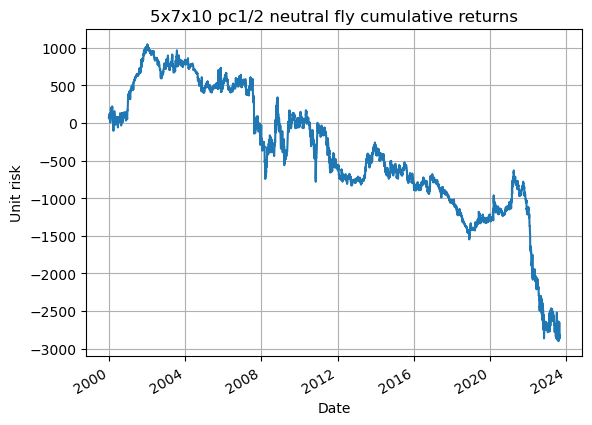

In [ ]:
(pc_neutral_return_agg.cumsum()*1e4).plot()
plt.title('5x7x10 pc1/2 neutral fly cumulative returns')
plt.ylabel('Unit risk')
plt.grid(True)

In [ ]:
signal = (pc_neutral_return_agg_lag - pc_neutral_return_agg_lag.ewm(halflife=100).mean())/ pc_neutral_return_agg_lag.ewm(halflife=60).std()

In [ ]:
retagg = pc_neutral_return_agg.cumsum()
signal_contemp = (retagg - retagg.ewm(halflife=100).mean())/ retagg.ewm(halflife=60).std()

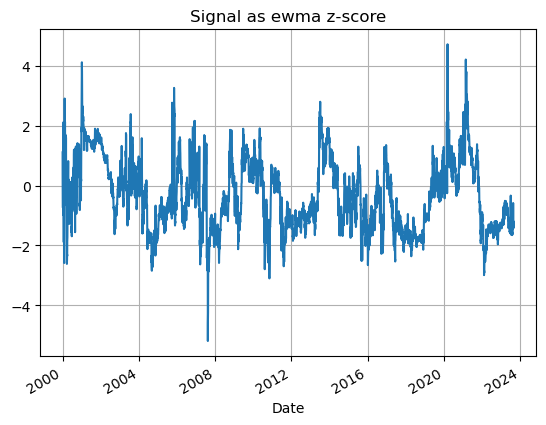

In [ ]:
signal.plot()
plt.title('Signal as ewma z-score')
plt.grid()

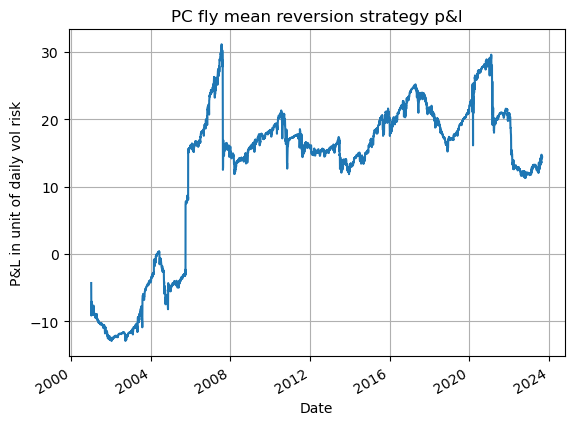

In [ ]:
strategy_return = (-signal * pc_neutral_return_agg / pc_neutral_return_agg_lag.ewm(halflife=60).std() )
strategy_return['20010101':].cumsum().plot()
plt.title('PC fly mean reversion strategy p&l')
plt.ylabel('P&L in unit of daily vol risk')
plt.grid(True)

In [ ]:
df=strategy_return['20010101':]
sharpe=(df.mean())/df.std()*np.sqrt(252)
sharpe

0.10330691592725193

The plot below is for a strategy where the signal is not delayed by 1 day.  In general this produces unrealistic returns in mean reversion strategies

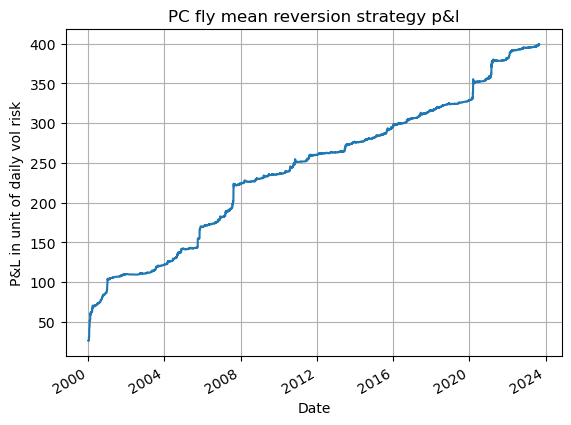

In [ ]:
(signal_contemp * pc_neutral_return_agg / pc_neutral_return_agg_lag.ewm(halflife=60).std() ).cumsum().plot()
plt.title('PC fly mean reversion strategy p&l')
plt.ylabel('P&L in unit of daily vol risk')
plt.grid(True)